<a href="https://colab.research.google.com/github/sha7cs/Sentiment_prediction/blob/main/Sentiment_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Machine Learning and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Deep Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Input, LSTM, Dense, concatenate, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers


In [ ]:
nlp = spacy.load('en_core_web_sm')

# Load and cleaning the data

In [ ]:
reviews = pd.read_csv('/content/IMDB Dataset.csv')
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
reviews.shape

(50000, 2)

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
for i in range(4):
    print("Review: ", [i])
    print(reviews['review'].iloc[i], "\n")
    print("Sentiment: ", reviews['sentiment'].iloc[i], "\n\n")

Review:  [0]
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

In [ ]:
reviews['bisentiment']= reviews['sentiment'].map({'positive':1, 'negative':0})

In [ ]:
reviews.head()

,review,sentiment,bisentiment
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
reviews.drop(columns ='sentiment',inplace = True)

In [ ]:
reviews.shape[0]

50000

the instances are too big so i took 5000 to make the process easier

In [ ]:
new_reviews, _ = train_test_split(reviews, train_size=5000, stratify=reviews['bisentiment'], random_state=42)

all the pre-processing functions

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

def clean_review(text):
    text = re.sub(r'<br\s*\/?>', '', text)   # it will remove <br />
    text = re.sub(r'-', ' ', text)   # it will remove -
    text = re.sub(r'\s+', ' ', text).strip()   # it will remove extra spaces
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

def clean_text(text):

    unwanted_chars = {'\xad', '\x80', '\x84', '\x8d', '\x8e', '\x91',
                      '\x95', '\x96', '\x97', '\x9a', '\x9e', '\x08', '\x10',
                      '{', '|', '}', '~','@', '[', '\\', ']', '^', '_', '`',
                      ':', ';', '<', '=', '>','/','(', ')', '*', '+', ',', '-',
                      '#', '$', '%', '&','\uf0b7','，', '¡','¢','£','¤','¦','§',
                      '¨','©','ª','«','®','°','³','´','·','º','»','½','¾','¿',
                      'ß','à','á','â','ã','ä','å','æ','ç','è','é','ê','ë','ì',
                      'í','î','ï','ð','ñ','ò','ó','ô','õ','ö','ø','ù','ú','û',
                      'ü','ý','þ','ğ','ı','ō','ż','א','ג','ו','י','כ','ל',
                      'מ','ן','ר','–','‘','’','“','”','…','″','₤','▼','★','、',
                      'à','á','â','ã','ä','å','æ','ç','è','é','ê','ï','ð','ó','õ','ö','ø','ü','þ','ż'}


    allowed_chars = {' ', '!', '"', "'", '.','0','1','2','3','4','5','6','7','8','9','?',
                     'a','A','b','B','c','C','d','D','e','E','f','F','g','G','h','H','i','I',
                     'j','J','k','K','l','L','m','M','n','N','o','O','p','P','q','Q','r','R',
                     's','S','t','T','u','U','v','V','w','W','x','X','y','Y','z','Z'}

    cleaned_text = ''.join([char for char in text if char not in unwanted_chars])
    return cleaned_text

def to_lower(text):
    return text.lower()

def remove_stopwords(text):
    doc = nlp(text)
    return " ".join(token.text for token in doc if token.text not in STOP_WORDS)

def lemmatize(text):
    doc = nlp(text)
    return " ".join(token.lemma_ for token in doc)


def clean_dots(text):
    cleaned_text = re.sub(r'\.{2,}', '.', text)
    return cleaned_text


def count_words(text):
    doc = nlp(text)
    num_words = len(doc)
    return num_words

def count_sentences(text):
    doc = nlp(text)
    num_sentences = len(list(doc.sents))
    return num_sentences


In [ ]:
new_reviews['to_lower'] =new_reviews['review'].apply(to_lower)
new_reviews['remove_stopwords'] =new_reviews['to_lower'].apply(remove_stopwords)
new_reviews['lemmatize'] =new_reviews['remove_stopwords'].apply(lemmatize)
new_reviews['review_cleaned'] =new_reviews['lemmatize'].apply(clean_review)
new_reviews['cleanedreview'] =new_reviews['review_cleaned'].apply(clean_text)
new_reviews['cleaned_review'] =new_reviews['cleanedreview'].apply(clean_dots)
new_reviews.drop(columns = ['review','to_lower','remove_stopwords','lemmatize','review_cleaned','cleanedreview'],inplace = True)

new_reviews['words'] = new_reviews['cleaned_review'].apply(count_words)
new_reviews['sentences'] = new_reviews['cleaned_review'].apply(count_sentences)

In [ ]:
new_reviews.head()

,bisentiment,cleaned_review,words,sentences
0,0,get dvd cheap total drewbie s probably conste...,79,5
1,1,like comedy . smith slow . right target great ...,100,14
2,0,piece junk movie . premise okay begin crappy ...,71,7
3,1,big fan movie usual reason . think travolta w...,119,10
4,1,m go fairly brief spoil . movie awesome . begi...,112,14


## load the data after pre-processing

save the file after we updated the data

In [ ]:
new_reviews.to_csv('new_imdb_dataset.csv', index = False)

In [ ]:
new_reviews = pd.read_csv('/content/new_imdb_dataset.csv')

In [ ]:
new_reviews.head()

,bisentiment,cleaned_review,words,sentences
0,0,get dvd cheap total drewbie s probably conste...,79,5
1,1,like comedy . smith slow . right target great ...,100,14
2,0,piece junk movie . premise okay begin crappy ...,71,7
3,1,big fan movie usual reason . think travolta w...,119,10
4,1,m go fairly brief spoil . movie awesome . begi...,112,14


# plots

In [ ]:
!!pip install plotly

['Requirement already satisfied: plotly in /usr/local/lib/python3.10/dist-packages (5.15.0)',
 'Requirement already satisfied: tenacity>=6.2.0 in /usr/local/lib/python3.10/dist-packages (from plotly) (8.2.3)',
 'Requirement already satisfied: packaging in /usr/local/lib/python3.10/dist-packages (from plotly) (24.0)']

In [ ]:
import plotly.express as px

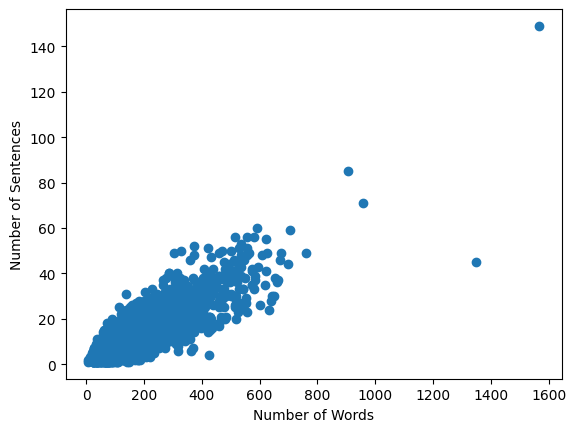

In [ ]:
num_words = new_reviews['words']
num_sentences = new_reviews['sentences']

plt.scatter(num_words, num_sentences)
plt.xlabel('Number of Words')
plt.ylabel('Number of Sentences')
plt.show()

Text(0.5, 1.0, 'Sentiment distribution')

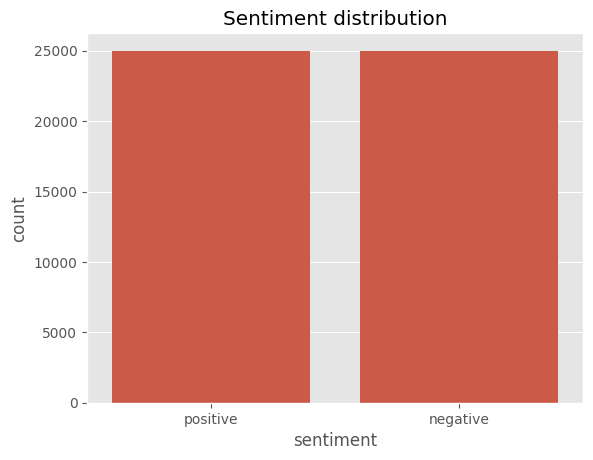

In [ ]:
sns.countplot(x='sentiment', data=reviews)
plt.title("Sentiment distribution")

In [ ]:
pos_reviews =  new_reviews[new_reviews.bisentiment == 1]
neg_reviews =  new_reviews[new_reviews.bisentiment == 0]

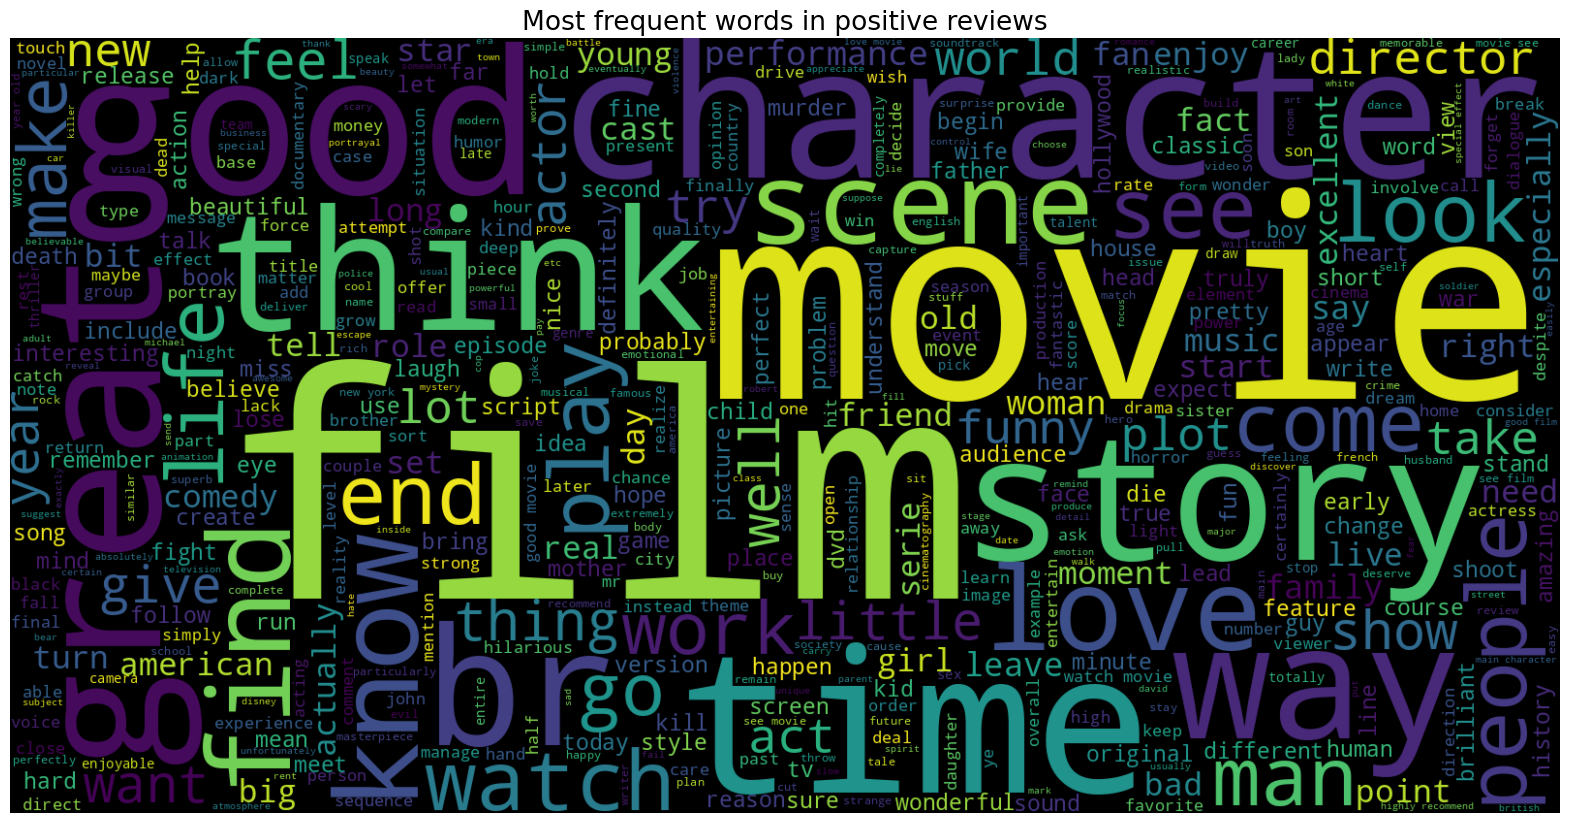

In [ ]:
from wordcloud import WordCloud
text = ' '.join([word for word in pos_reviews['cleaned_review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

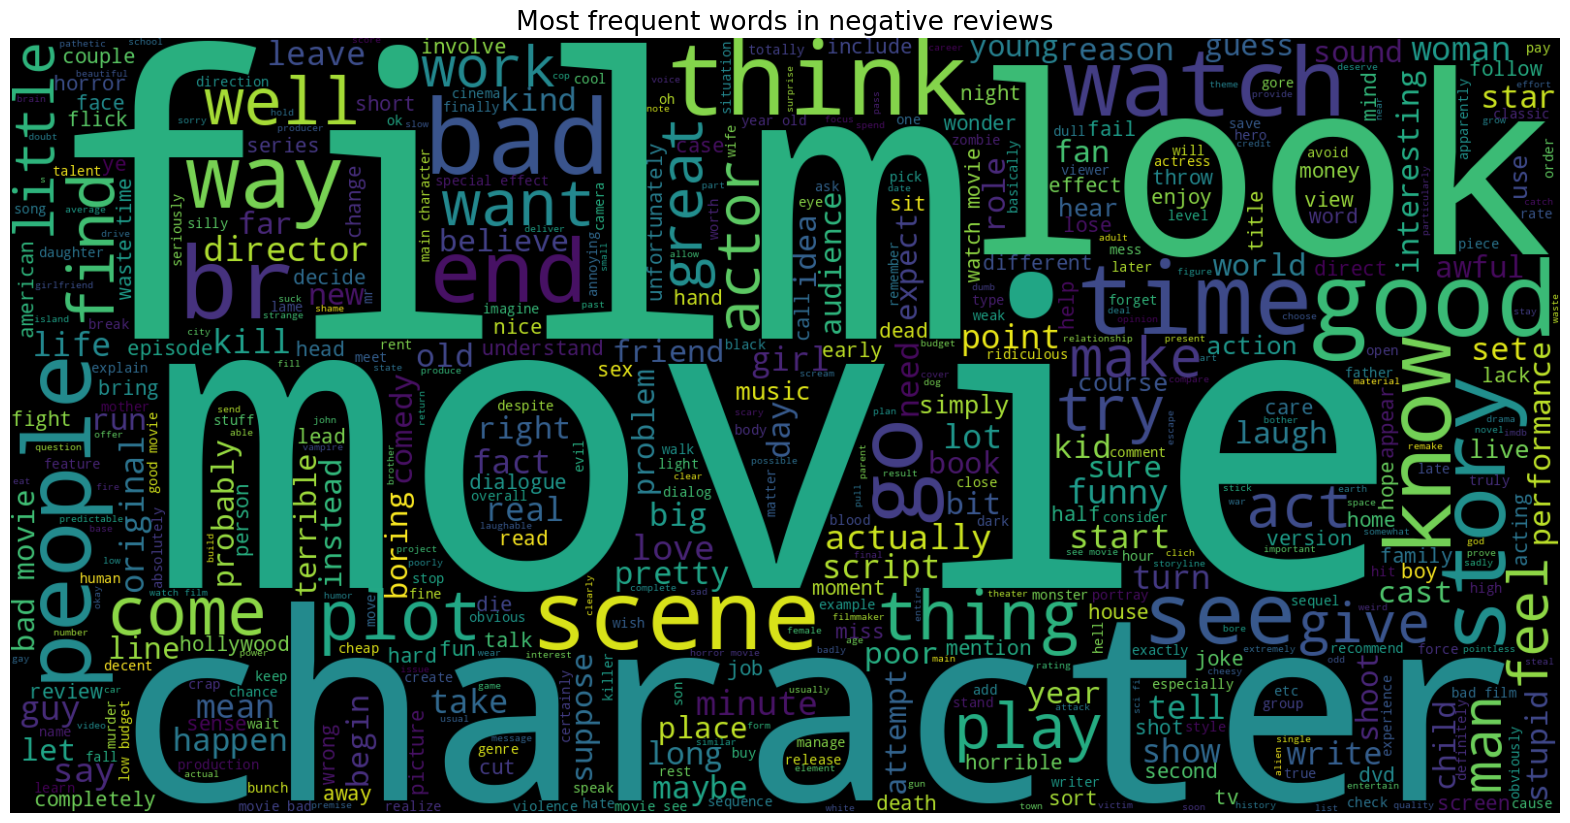

In [ ]:
text = ' '.join([word for word in neg_reviews['cleaned_review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize = 19)
plt.show()

# training

Split the data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_reviews['cleaned_review'], new_reviews['bisentiment'], test_size=0.2, random_state=42)

In [ ]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (34704, 221707)
Size of y_train:  (3999,)
Size of x_test:  (14874, 221707)
Size of y_test:  (1000,)


Convert the text data into numerical features that machine learning algorithms can work with.

In [ ]:
vectorizer = TfidfVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

## Logistic regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_features, y_train)
logreg_pred = logreg.predict(X_test_features)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 85.50%


In [ ]:
import sklearn.metrics

print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[424  85]
 [ 60 431]]


              precision    recall  f1-score   support

           0       0.88      0.83      0.85       509
           1       0.84      0.88      0.86       491

    accuracy                           0.85      1000
   macro avg       0.86      0.86      0.85      1000
weighted avg       0.86      0.85      0.85      1000



## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_features, y_train)
# Evaluate
y_pred_rf = rf.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred_rf)
print("Test accuracy: {:.2f}%".format(accuracy*100))

Test accuracy: 84.00%


In [ ]:
print(confusion_matrix(y_test, y_pred_rf ))
print("\n")
print(classification_report(y_test, y_pred_rf ))

[[425  84]
 [ 76 415]]


              precision    recall  f1-score   support

           0       0.85      0.83      0.84       509
           1       0.83      0.85      0.84       491

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



## SVM

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_train_features, y_train)
# Evaluate
predictions = svm.predict(X_test_features)
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {:.2f}%".format(accuracy*100))

Test accuracy: 87.10%


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\n")

print("Classification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[432  77]
 [ 52 439]]


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       509
           1       0.85      0.89      0.87       491

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



# using the trained models

a function that would use the models to predict the sentiment at any given sentence

In [ ]:
def preprocess(review):
    cleaned_review = clean_review(review)
    cleaned_text = clean_text(cleaned_review)
    lowered = to_lower(cleaned_text)
    removed_sp = remove_stopwords(lowered)
    final_text= lemmatize(removed_sp)
    return final_text

In [ ]:
def predict_sentiment(sentence):

    cleaned_sentence = preprocess(sentence)
    sentence_features = vectorizer.transform([cleaned_sentence])

    # Make the prediction using the trained SVM model
    prediction = svm.predict(sentence_features)

    sentiment = "Positive" if prediction == 1 else "Negative"

    return sentiment

In [ ]:
sentence = 'i loved this movie it was great'
predicted_sentiment = predict_sentiment(sentence)
print(f"Sentence sentiment: {predicted_sentiment}")

Sentence sentiment: Positive


In [ ]:
sentence = 'so long '
predicted_sentiment = predict_sentiment(sentence)
print(f"Sentence sentiment: {predicted_sentiment}")

Sentence sentiment: Negative
